What is the global trend in the cotton trading area in the last 10 years? Let's clrean up the Foreign Agricultural Service dataset about cotton and display an overall picture.

In [103]:
import pandas as pd
df_global_cotton_trade = pd.read_csv("psd_cotton.csv")  
cleaned_data = df_global_cotton_trade[df_global_cotton_trade['Market_Year'] >= 2005]
cleaned_data = cleaned_data.drop(columns=['Calendar_Year'])
print(cleaned_data['Attribute_Description'].unique())


['Area Harvested' 'Beginning Stocks' 'Domestic Use' 'Ending Stocks'
 'Exports' 'Imports' 'Loss' 'Production' 'Stocks-to-Use'
 'Total Distribution' 'Total Supply' 'Yield']


- **Area Harvested** → Land actually harvested for cotton
- **Beginning Stocks** → Cotton carried over from previous season’s ending stocks
- **Domestic Use** → Cotton consumed by domestic mills within a country
- **Ending Stocks** → Cotton remaining in inventory at the close of season
- **Exports** → Cotton shipments sent abroad during the marketing year
- **Imports** → Cotton shipments brought into the country during the year
- **Loss** → Loss in PS&D datasets does not always mean physical loss. It represents adjustments needed to balance the supply-demand equation (if the value is positive, actual or estimated physical loss)
- **Production** → Cotton lint output from harvested fields during the season
- **Stocks-to-Use** → Ending stocks compared with domestic use and exports
- **Total Distribution** → Domestic use plus exports plus losses of cotton
- **Total Supply** → Beginning stocks plus production plus imports available
- **Yield** → Production of cotton lint per unit of harvested area

First of all, we could transform the dataset by adding as many columns as the unique attributes we listed here, so that the data will be more easy to access per country and per year.
Having this attributes, we could startign by displaying the total production of cotton and catch the first 5 countires in the world.

In [104]:
pivoted_data = cleaned_data.pivot_table(
    index=['Commodity_Code', 'Commodity_Description', 'Country_Code', 'Country_Name', 'Market_Year', 'Month'],
    columns='Attribute_Description',
    values=['Unit_Description', 'Value'],
    aggfunc='first'
)

pivoted_data.columns = [f'{attr}_{col}' for col, attr in pivoted_data.columns]
pivoted_data.reset_index(inplace=True)
pivoted_data.drop(columns=['Attribute_ID'], errors='ignore', inplace=True)
pivoted_data.to_csv('transformed_psd_cotton.csv', index=False)

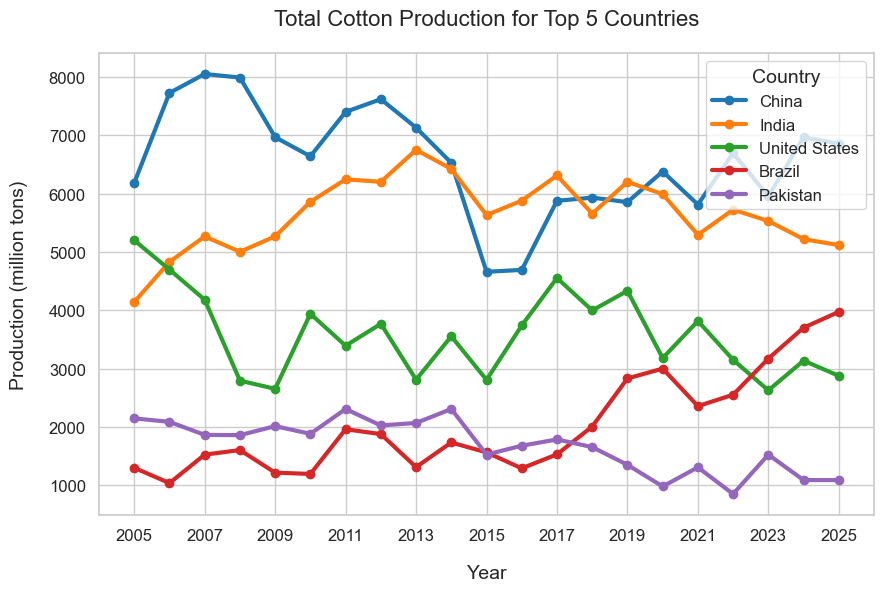

In [74]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pivoted_data['Area_Harvested_ha'] = pivoted_data['Area Harvested_Value'] * 1000 # now in ha
pivoted_data['Loss_kg'] = pivoted_data['Loss_Value'].apply(lambda x: x * 218 if x > 0 else 0) # now in kg, avoiding negative corrections

# Production_tot = (Yield × Area Harvested)-Loss in million tons
pivoted_data['Production_tot'] = ((pivoted_data['Yield_Value'] * pivoted_data['Area_Harvested_ha']) - pivoted_data['Loss_kg'])/ 1_000_000
top_countries = pivoted_data.groupby('Country_Name')['Production_tot'].sum().nlargest(5).index
filtered_data = pivoted_data[pivoted_data['Country_Name'].isin(top_countries)]

# Assign unique colors to top countries
color_map = {country: color for country, color in zip(top_countries, cm.tab10.colors)}

filtered_data.to_csv('top_5_prod_countires.csv', index=False)

plt.figure(figsize=(10, 6))
for country in top_countries:
    country_data = filtered_data[filtered_data['Country_Name'] == country]
    plt.plot(
        country_data['Market_Year'],
        country_data['Production_tot'],
        label=country,
        linewidth=3,
        marker='o',
        color=color_map[country]
        
    )

plt.title('Total Cotton Production for Top 5 Countries', pad=20, fontsize=16)  # Add padding and increase title font size
plt.xlabel('Year', labelpad=15, fontsize=14)  # Move x-axis label further and increase font size
plt.ylabel('Production (million tons)', labelpad=15, fontsize=14)  # Move y-axis label further and increase font size
years = filtered_data['Market_Year'].unique()
plt.xticks(ticks=years[::2], rotation=0, fontsize=12)  # Increase font size of x-axis ticks
plt.yticks(fontsize=12)  # Increase font size of y-axis ticks
plt.legend(title='Country', loc='upper right', fontsize=12, title_fontsize=14)  # Adjust legend font sizes
plt.grid(True)
plt.show()

China is very competitive in this market, and its trend is interesting: worth investigating. What is the relation between the total production and the trade? Which is, between the top productors, the country that exports the most?

/var/folders/fx/4n7zrjcn0ng53w2cl_t87vp80000gn/T/ipykernel_17625/958465838.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0,2, 1.5])


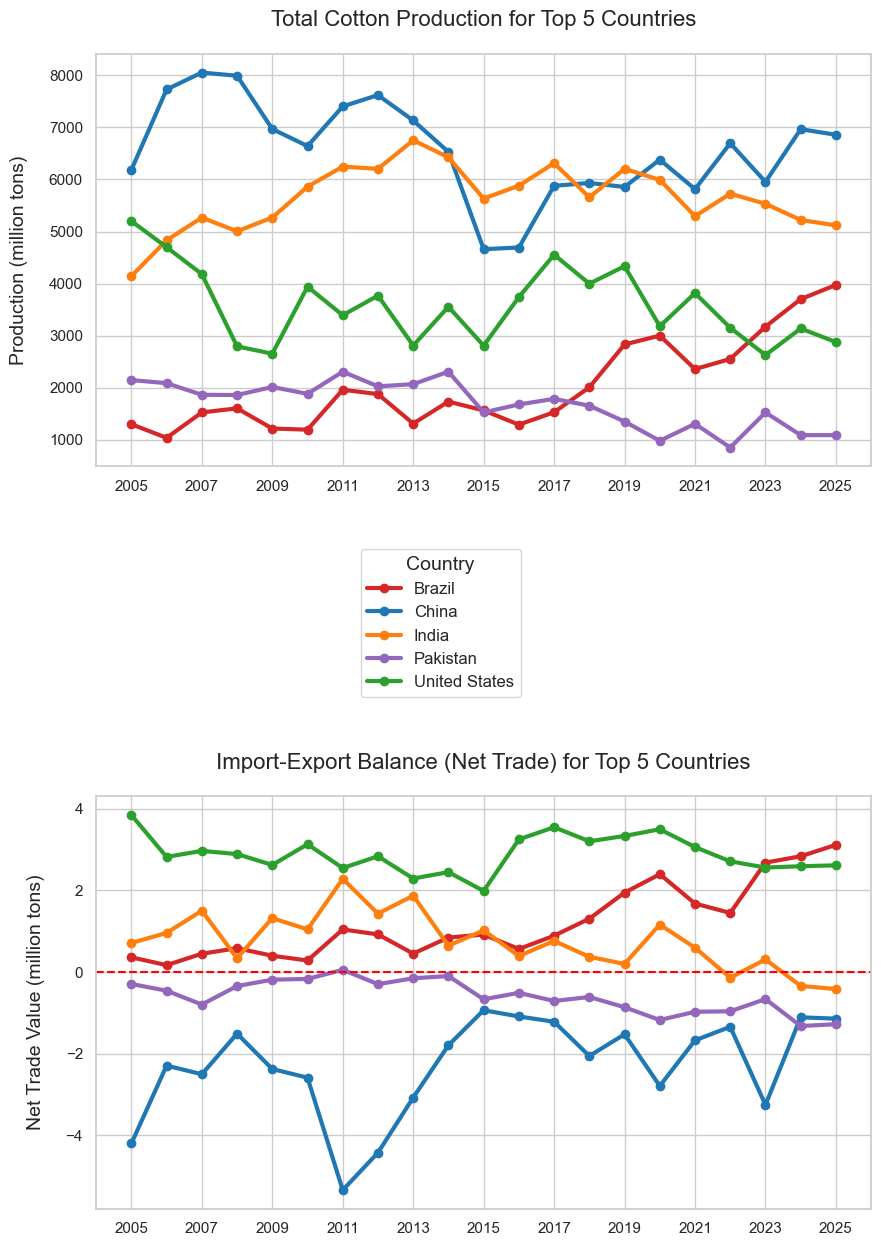

In [ ]:
df_top5 = pd.read_csv("top_5_prod_countires.csv")  

# calculate net trade (Import-Export balance)
df_top5.loc[:, 'Net_Trade'] = (df_top5['Exports_Value'] - df_top5['Imports_Value']).apply(lambda x: x * 218)/ 1_000_000

fig, axes = plt.subplots(2, 1, figsize=(10, 15), sharex=True, gridspec_kw={'hspace': 0.8})

# total Production for the top 5 countries
axes[0].set_title('Total Cotton Production for Top 5 Countries', pad=20, fontsize=16)
for country in df_top5['Country_Name'].unique():
    country_data = df_top5[df_top5['Country_Name'] == country]
    axes[0].plot(
        country_data['Market_Year'],
        country_data['Production_tot'],
        label=country,
        linewidth=3,
        marker='o',
        color=color_map[country]
    )
axes[0].set_ylabel('Production (million tons)', labelpad=15, fontsize=14)
axes[0].set_xlabel('Year', labelpad=15, fontsize=14) 
axes[0].tick_params(labelbottom=True)

axes[0].grid(True)

# Net Trade for the same top 5 countries
axes[1].set_title('Import-Export Balance (Net Trade) for Top 5 Countries', pad=20, fontsize=16)
for country in df_top5['Country_Name'].unique():
    country_data = df_top5[df_top5['Country_Name'] == country]
    axes[1].plot(
        country_data['Market_Year'],
        country_data['Net_Trade'],
        linewidth=3,
        marker='o',
        label=country,
        color=color_map[country]
    )
axes[1].axhline(0, color='red', linestyle='--', label='Balance Line')
axes[1].set_xlabel('Year', labelpad=15, fontsize=14)
axes[1].set_ylabel('Net Trade Value (million tons)', labelpad=15, fontsize=14)
axes[1].grid(True)

years = df_top5['Market_Year'].unique()
axes[0].set_xticks(years[::2])
axes[1].set_xticks(years[::2])

# legend outside the panels
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', fontsize=12, title='Country', title_fontsize=14)
plt.tight_layout(rect=[0, 0,2, 1.5])
plt.show()